In [1]:
edges_path = 'data/course3_edge.csv'
test_path = 'data/course3_test.csv'
submission_path = 'data/course3_submissionsample.csv'

In [2]:
from node2embedding import NodeEmbedding
import pandas as pd
import numpy as np
import networkx as nx

In [3]:
# get edges and nodes
edges = pd.read_csv(edges_path)
edges = edges.values
nodes = np.unique(edges)
test_edges = pd.read_csv(test_path).values[:, 1:]
test_nodes = np.unique(test_edges)
nodes_all = np.unique(np.hstack([nodes, test_nodes]))  # get all nodes
print(len(nodes_all))

16863


In [4]:
# get the edges and nodes info
print('The total edges: {}'.format(edges.shape[0]))
print('The number of sourse nodes: {}'.format(len(np.unique(edges[:, 0]))))
print('The number of target nodes: {}'.format(len(np.unique(edges[:, 1]))))
print('The number of total nodes: {}'.format(len(np.unique(edges))))
print('The max node index: {}'.format(np.max(edges)))

The total edges: 46116
The number of sourse nodes: 12061
The number of target nodes: 13832
The number of total nodes: 16735
The max node index: 16862


In [5]:
# get all ranom walks and train the Word2Vec model
train = False
if train:
    node2vec = NodeEmbedding(random_policy='node2vec', epochs=20, path_length=80, num_random=10, workers=4, 
                             dimensions=128, p=1, q=1, window_size=10)
    node2vec.fit(edges, nodes_all)
else:  # use the already trained model
    node2vec = NodeEmbedding(random_policy='node2vec', epochs=20, path_length=80, num_random=10, workers=4, 
                             dimensions=128, p=1, q=1, window_size=10)
    node2vec.fit(edges, nodes_all, model_path='word2vec.model')

Creating the graph has finished...
Load the pre-trained model...


In [6]:
test_labels, test_probs = node2vec.predict(test_edges)
submission = pd.read_csv(submission_path)
df = pd.DataFrame(columns=['id', 'label'])
df['id'] = np.array(range(len(test_probs)))  # save the probabilities
df['label'] = test_probs
df.to_csv('data/submission.csv', index=None)

Begin to train the classifier...


C:\Users\hppc\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Have done classifier training process, the train auc score: 0.9952876689161241


In [7]:
# Compare to my best submission result
sub = pd.read_csv('data/submission.csv').values
sub_best = pd.read_csv('data/submission_final.csv').values
label1 = sub[:, 1] > 0.5
label2 = sub[:, 1] > 0.5
print(sum(label1 == label2) / len(label1))

# In above, we get labels from the predict method, this can also be done as follows step by step

1.0


In [8]:
edge_functions = {
    "hadamard": lambda a, b: a * b,
    "average": lambda a, b: 0.5 * (a + b),
    "l1": lambda a, b: np.abs(a - b),
    "l2": lambda a, b: np.abs(a - b) ** 2,
}
# get positive edge features
pos_edge_features = node2vec.get_edge_features(edges, edge_fn=edge_functions['hadamard'])
print(pos_edge_features.shape)

(46116, 128)


In [9]:
# get negative edge features
neg_edges = pd.read_csv('data/neg_edges.csv')
neg_edges = neg_edges.values[:50000]
neg_edge_features = node2vec.get_edge_features(neg_edges, edge_fn=edge_functions['hadamard'])
print(neg_edge_features.shape)

(50000, 128)


In [10]:
print(pos_edge_features.shape)
print(neg_edge_features.shape)
train_pos_labels = np.full((pos_edge_features.shape[0], ), 1)  # positive labels
train_neg_labels = np.full((neg_edge_features.shape[0], ), 0)  # negative labels
train_labels = np.hstack([train_pos_labels, train_neg_labels])  # create train labels
edges_features_train = np.vstack([pos_edge_features, neg_edge_features])  # create train edge features

(46116, 128)
(50000, 128)


In [11]:
# train classifier, use Multi-layer Perceptron as the classifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=20, alpha=1e-4,
                    solver='sgd', verbose=10, random_state=1,
                    learning_rate_init=.1)
X_train, X_test, y_train, y_test = train_test_split(edges_features_train, train_labels)
mlp.fit(X_train, y_train)
print(mlp.score(X_test, y_test))
score = roc_auc_score(mlp.predict(X_test), y_test)
print(score)

Iteration 1, loss = 0.06497084
Iteration 2, loss = 0.02526877
Iteration 3, loss = 0.02040728
Iteration 4, loss = 0.01600339
Iteration 5, loss = 0.01296278
Iteration 6, loss = 0.01110995
Iteration 7, loss = 0.00948738
Iteration 8, loss = 0.00824680
Iteration 9, loss = 0.00659675
Iteration 10, loss = 0.00628194
Iteration 11, loss = 0.00556529
Iteration 12, loss = 0.00532455
Iteration 13, loss = 0.00430454
Iteration 14, loss = 0.00352278
Iteration 15, loss = 0.00326037
Iteration 16, loss = 0.00284108
Iteration 17, loss = 0.00312093
Iteration 18, loss = 0.00236183
Iteration 19, loss = 0.00238713
Iteration 20, loss = 0.00199528


C:\Users\hppc\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.9942985559116068
0.9942975250036713


In [12]:
print(np.sum(mlp.predict(pos_edge_features) == 1))
print(np.sum(mlp.predict(neg_edge_features) == 1))

46022
72


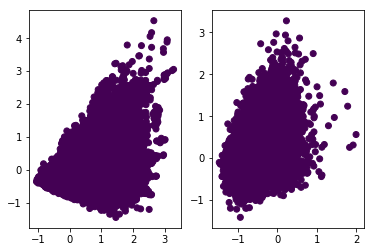

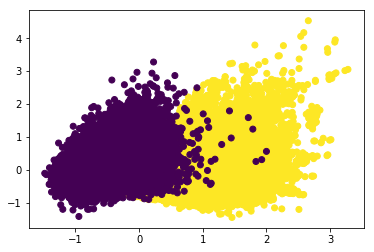

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
edge_features_pca=pca.fit_transform(edges_features_train)
# edge_features_pca=scaler.fit_transform(edge_features_pca)
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.scatter(edge_features_pca[:46116, 0], edge_features_pca[:46116, 1], c=train_labels[:46116])
plt.subplot(1, 2, 2)
plt.scatter(edge_features_pca[46116:, 0], edge_features_pca[46116:, 1], c=train_labels[46116:])
plt.figure(2)
plt.scatter(edge_features_pca[:, 0], edge_features_pca[:, 1], c=train_labels)
plt.show()

In [15]:
# get test edge features
print(test_edges.shape)
test_edges_features = node2vec.get_edge_features(test_edges, edge_fn=edge_functions['hadamard'])

(10246, 2)


In [16]:
test_labels = mlp.predict(test_edges_features)  # predict test labels
test_probs = mlp.predict_proba(test_edges_features)[:, 1]  # predict probs

In [17]:
submission = pd.read_csv(submission_path)
df = pd.DataFrame(columns=['id', 'label'])
df['id'] = np.array(range(len(test_probs)))
df['label'] = test_probs
df.to_csv('data/submission.csv', index=None)

In [18]:
# Compare to my best submission result
sub = pd.read_csv('data/submission.csv').values
sub_best = pd.read_csv('data/submission_final.csv').values
label1 = sub[:, 1] > 0.5
label2 = sub[:, 1] > 0.5
print(sum(label1 == label2) / len(label1))

1.0
